# Segmentación semantica usando red neuronal convolucional

La segmentación semantica consiste en clasificar cada uno de los pixeles de una imagen en distintas clases.  

https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge/home

http://groups.csail.mit.edu/vision/datasets/ADE20K/

### Acerca del dataset

El conjunto de imagenes que se usará lo provee https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge/home, el cual consiste de 5000 imagenes.

Cada una de las imagenes tiene un tamaño de 600x800, donde se juntan la imagen original y su respectiva máscara de segmentación semántica.

En la máscara de segmentación semántica 13 clases:

1. Construcciones
2. Cercas
3. Otros
4. Peatones 
5. Postes 
6. Lineas de la carretera
7. Carretera
8. Banqueta
9. Vegetación
10. Vehículos
11. Paredes
12. Señal de tráfico

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
# Conversion de etiquetas a colores RGB
label2color = {
    0: (0, 0, 0),
    1: (70, 70, 70),
    2: (190, 153, 153),
    3: (250, 170, 160),
    4: (220,  20,  60), 
    5: (153, 153, 153), 
    6: (153, 153, 153), 
    7: (128, 64, 128), 
    8: (244, 35, 232),
    9: (107, 142, 35), 
    10: (0, 0, 142), 
    11: (102, 102, 156), 
    12:(220, 220, 0)
}

In [7]:
data_imgs = []
data_targets = []

width = 512
height = 512

path = '/floyd/input/carla_ds/dataset/'
img_names = os.listdir(path + 'data')
target_names = os.listdir(path + 'targets')

for img, target in zip(img_names[:3500], target_names[:3500]):
    im = cv2.imread(path + 'data/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_imgs.append(im)
    im = cv2.imread(path + 'targets/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_targets.append(im)
    
data_imgs = np.array(data_imgs)
data_targets = np.array(data_targets)

In [8]:
def label2image(img, num_classes=13, height=512, width=512):
    '''
        Toma como entrada una imagen con los valores de las clases 
        en cada pixel y regresa su representacion en colores RGB 
        para poder visualizar la segmentacion semantica.
    '''
    color_mask = np.zeros((height, width, 3), np.uint8())
    for i in range(0, num_classes):
        B, G = np.where(img==i) 
        for r, c in zip(B, G):
            red, green, blue = label2color[i]
            color_mask[r,c,0] = red
            color_mask[r,c,1] = green
            color_mask[r,c,2] = blue
    return color_mask

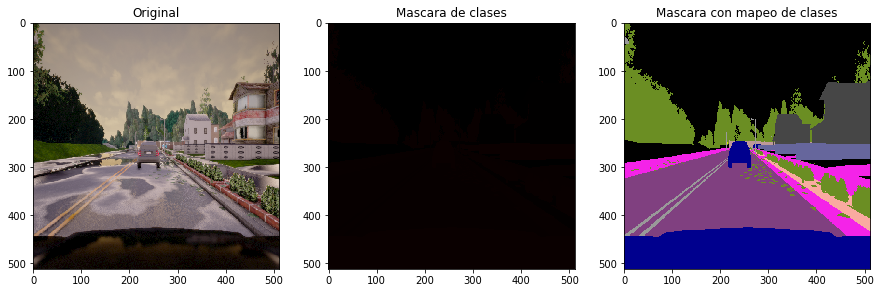

In [9]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(data_imgs[0])
plt.title('Original')
plt.subplot(132)
plt.title('Mascara de clases')
plt.imshow(data_targets[0])
plt.subplot(133)
plt.imshow(label2image(data_targets[0][:,:,0]))
plt.title('Mascara con mapeo de clases')
plt.show()
fig.savefig('test.png')

## Codificacion de las imagenes target

La entrada de la red neuronal convolucional es un tensor con dimensiones (height, widht, 3), la salida es un tensor con dimensiones (height, width, 12).

En este dataset, la imagen objetivo tiene las etiquetas de cada pixel codificadas en el canal rojo (como números enteros del 1 al 12), por lo que en principo tiene dimensiones (height, width, 3). Para que la red neuronal pueda ser entrenada, es necesario codificar la imagen objetivo o tensor con dimensiones (height, width, 12). 

One hot encoding es usado para codificar la imagen objetivo original en un tensor donde cada canal indica con 1's la clase de cada pixel.

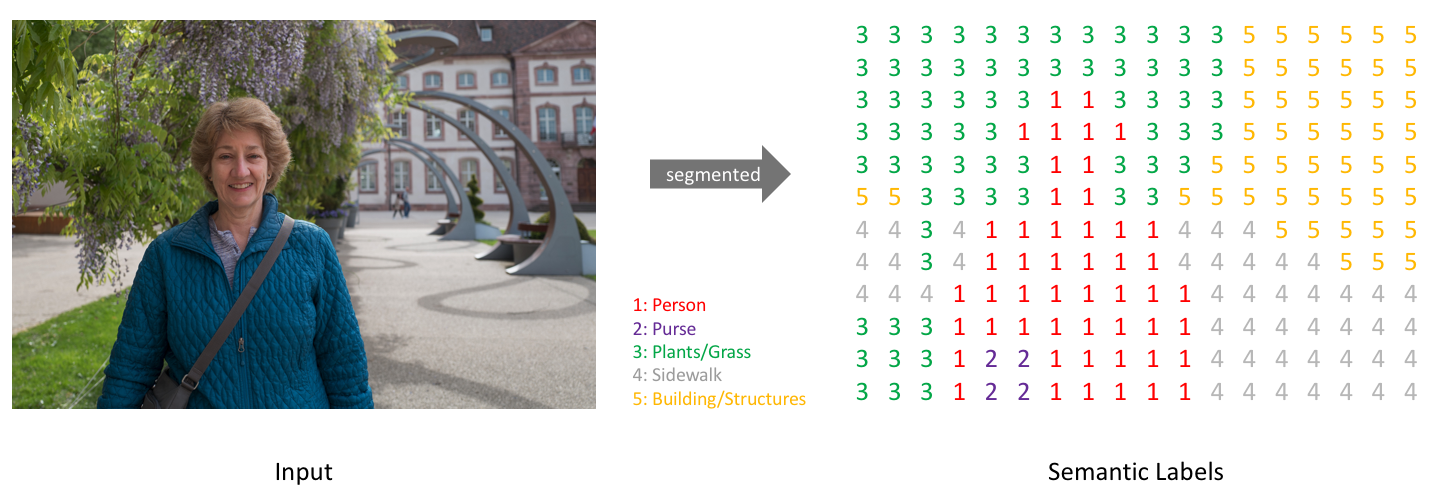

In [10]:
Image(filename="img/target_encoding.png", height=600, width=900)

One hot encoding


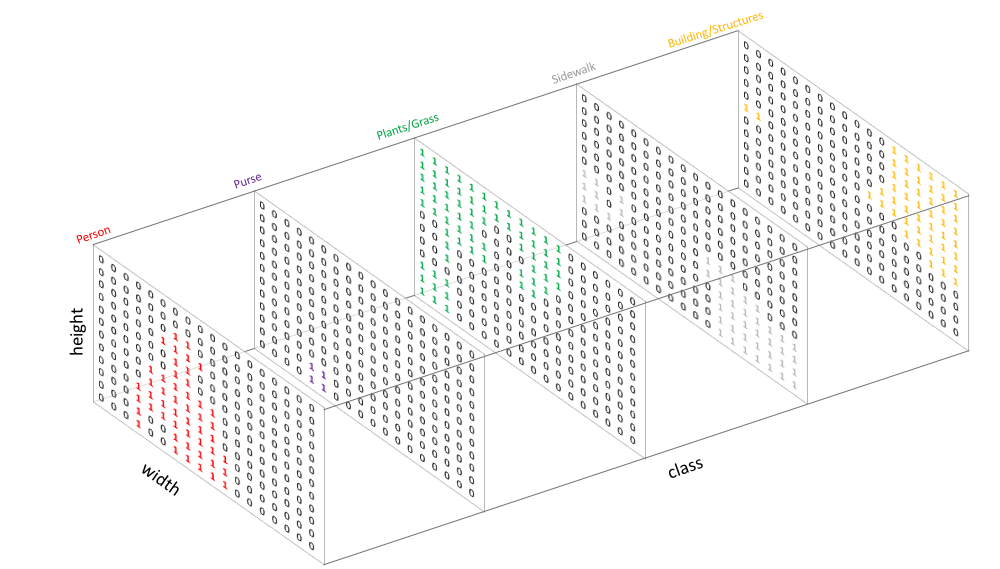

In [11]:
print('One hot encoding')
Image(filename="img/one_hot.png", height=500, width=900)

In [12]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [13]:
def one_hot_encode(imgs, height=512, width=512):
    one_hot = []
    for i in range(len(imgs)):
        im_class = to_categorical(imgs[i][:,:,0], dtype='uint8')
        if im_class.shape[2] < 13:
            while im_class.shape[2] < 13:
                zeros = np.zeros((height, width, 1), dtype='uint8')
                im_class = np.concatenate((im_class, zeros), axis=2)
        one_hot.append(im_class)
    return np.array(one_hot)

In [14]:
def make_mask(img):
    '''
        Entrada: Tensor de dimensiones (height, width, classes)
        Salida: Tensor de dimensiones (height, width)
        Se mapea la salida de la red neuronal a una sola matriz
        la cual contiene las clases de cada pixel. 
    '''
    return np.argmax(img, axis=-1)

In [15]:
targets_oneHot = one_hot_encode(data_targets)

(512, 512, 13)
(512, 512)
[[ 9  9  9 ...  0  0  0]
 [ 9  9  9 ...  0  0  0]
 [ 9  9  9 ...  0  0  0]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


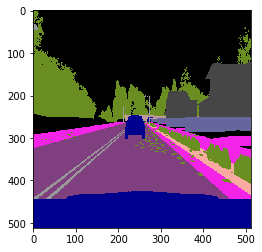

In [16]:
xx = targets_oneHot[0]
print(xx.shape)

yy = make_mask(xx)
print(yy.shape)

print(yy)

plt.figure()
plt.imshow(label2image(yy))
plt.show()

In [17]:
targets_oneHot.shape

(3500, 512, 512, 13)

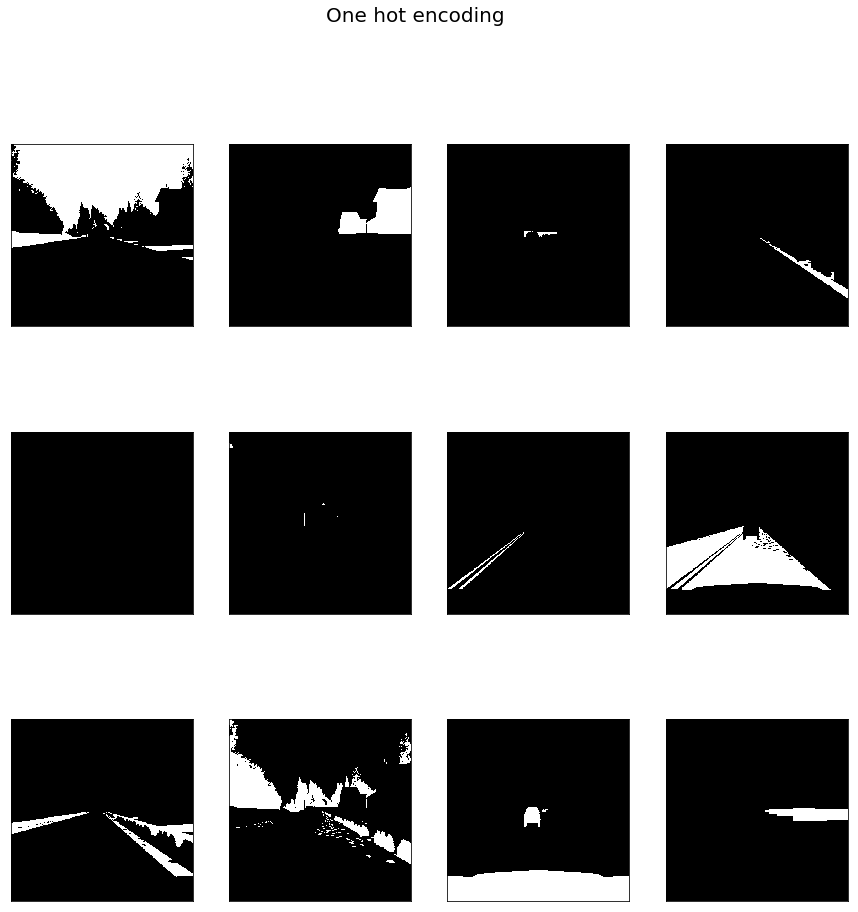

In [18]:
plt.figure(figsize=(15,15)).suptitle('One hot encoding', fontsize=20)
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(targets_oneHot[0][:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Creacion del modelo de red neuronal convolucional

In [19]:
from SegNet.model import segnet
from keras.optimizers import SGD

In [20]:
cnn = segnet(input_shape=(512, 512, 3), 
             n_labels=13,
             pool_size=(2, 2),
             output_mode='softmax')

Build enceder done..
Build decoder done..


In [21]:
cnn.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])

In [22]:
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
history = cnn.fit(data_imgs, targets_oneHot.reshape(3500, 262144, 13), validation_split=0.15, batch_size=5, epochs=10, shuffle=True)

Train on 2975 samples, validate on 525 samples
Epoch 1/10
2975/2975 [==============================] - 1904s 640ms/step - loss: 0.4334 - acc: 0.8694 - val_loss: 0.3108 - val_acc: 0.9061
Epoch 2/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.2230 - acc: 0.9314 - val_loss: 0.1900 - val_acc: 0.9410
Epoch 3/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.1640 - acc: 0.9487 - val_loss: 0.1905 - val_acc: 0.9381
Epoch 4/10
2975/2975 [==============================] - 1906s 641ms/step - loss: 0.1298 - acc: 0.9582 - val_loss: 0.1327 - val_acc: 0.9570
Epoch 5/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.1161 - acc: 0.9618 - val_loss: 0.1185 - val_acc: 0.9608
Epoch 6/10
2975/2975 [==============================] - 1906s 641ms/step - loss: 0.0959 - acc: 0.9676 - val_loss: 0.0999 - val_acc: 0.9661
Epoch 7/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.0847 - acc: 0.9708 - val_loss: 0.088

In [27]:
os.mkdir('model')

In [30]:
cnn.save('model/model.h5')
cnn.save_weights('model/weights.h5')

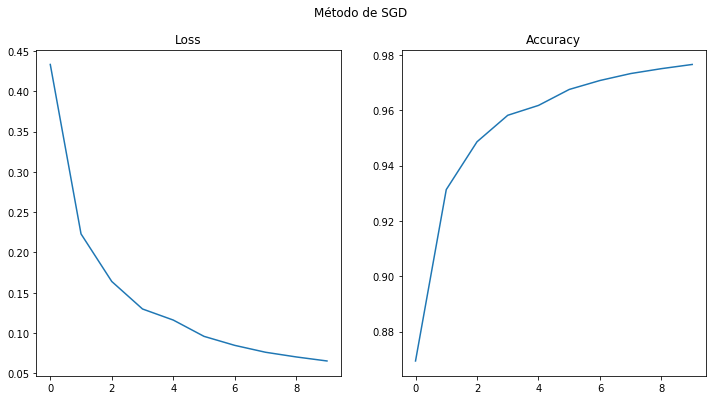

In [31]:
plt.figure(figsize=(12, 6)).suptitle('Método de SGD')
plt.subplot(121)
plt.plot(history.epoch, history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.epoch, history.history['acc'])
plt.title('Accuracy')
plt.show()

In [32]:
data_imgs = []
data_targets = []

path = '/floyd/input/carla_ds/dataset/'
img_names = os.listdir(path + 'data')
target_names = os.listdir(path + 'targets')

for img, target in zip(img_names[3500:], target_names[3500:]):
    im = cv2.imread(path + 'data/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_imgs.append(im)
    im = cv2.imread(path + 'targets/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_targets.append(im)
    
data_imgs = np.array(data_imgs)
data_targets = np.array(data_targets)

In [33]:
targets_oneHot = one_hot_encode(data_targets)

In [35]:
m1, m2 = cnn.evaluate(data_imgs, targets_oneHot.reshape(1500, 262144, 13))

1500/1500 [==============================] - 384s 256ms/step


In [45]:
print('Accuracy => %.2f' % (m2*100))

Accuracy => 97.25
